<a href="https://colab.research.google.com/github/suyashss/nn_test/blob/master/BEE-GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import tensorflow.keras as keras

In [3]:
tf.version

<module 'tensorflow_core._api.v2.version' from '/tensorflow-2.1.0/python3.6/tensorflow_core/_api/v2/version/__init__.py'>

In [4]:
tf.random.uniform([1,1]) < 0.05

<tf.Tensor: shape=(1, 1), dtype=bool, numpy=array([[False]])>

In [0]:
import matplotlib.pyplot as plt
def display_images(images,n):
  #print(images.shape)
  fig = plt.figure(figsize=(n*1.5,3))
  for i in range(n):
    img = (images[i,:,:]+1)/2
    plt.subplot(1,n,i+1)
    plt.imshow(img,cmap="binary")
    plt.axis("off")
  plt.show()    

In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving honey-bee-annotated-images.zip to honey-bee-annotated-images.zip
User uploaded file "honey-bee-annotated-images.zip" with length 52950294 bytes


In [7]:
!unzip honey-bee-annotated-images.zip

Archive:  honey-bee-annotated-images.zip
  inflating: bee_data.csv            
  inflating: bee_imgs/bee_imgs/001_043.png  
  inflating: bee_imgs/bee_imgs/001_044.png  
  inflating: bee_imgs/bee_imgs/001_046.png  
  inflating: bee_imgs/bee_imgs/001_047.png  
  inflating: bee_imgs/bee_imgs/001_050.png  
  inflating: bee_imgs/bee_imgs/001_051.png  
  inflating: bee_imgs/bee_imgs/001_054.png  
  inflating: bee_imgs/bee_imgs/001_056.png  
  inflating: bee_imgs/bee_imgs/001_078.png  
  inflating: bee_imgs/bee_imgs/001_082.png  
  inflating: bee_imgs/bee_imgs/001_083.png  
  inflating: bee_imgs/bee_imgs/001_085.png  
  inflating: bee_imgs/bee_imgs/001_091.png  
  inflating: bee_imgs/bee_imgs/001_092.png  
  inflating: bee_imgs/bee_imgs/001_093.png  
  inflating: bee_imgs/bee_imgs/001_094.png  
  inflating: bee_imgs/bee_imgs/001_095.png  
  inflating: bee_imgs/bee_imgs/001_096.png  
  inflating: bee_imgs/bee_imgs/001_097.png  
  inflating: bee_imgs/bee_imgs/001_118.png  
  inflating: bee_imgs

In [0]:
img_test = keras.preprocessing.image.load_img('bee_imgs/bee_imgs/046_197.png')

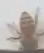

In [9]:
img_test

In [10]:
#%matplotlib inline
img_test.size

(44, 53)

In [0]:
img_gen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,vertical_flip=True,
                                                       preprocessing_function=lambda x: (x-127.5)/127.5)

In [0]:
image_dim=28

In [101]:
train_generator = img_gen.flow_from_directory(
          './bee_imgs/', target_size=(image_dim, image_dim),
      batch_size=12,color_mode='rgb',seed=1)

Found 5172 images belonging to 1 classes.


In [102]:
5172 % 12, 5172 /12

(0, 431.0)

In [0]:
(x_train,y_train)= train_generator.next()

In [104]:
x_train.shape,y_train.shape

((12, 28, 28, 3), (12, 1))

In [105]:
x_train[1,2,3,:]

array([-0.8352941 , -0.81960785, -0.84313726], dtype=float32)

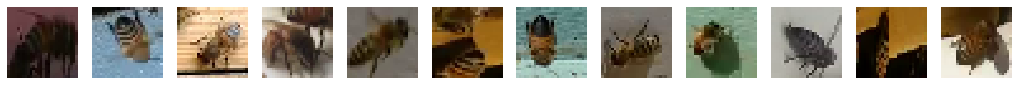

In [106]:
display_images(x_train.squeeze(),12)

In [107]:
type(x_train[0,0][0])

numpy.ndarray

In [108]:
x_train.shape

(12, 28, 28, 3)

In [109]:
tmp = x_train*2 - 1
tmp.shape

(12, 28, 28, 3)

In [0]:
batch_size=12

In [0]:
codings_size = 60

In [0]:
#generator = keras.models.Sequential([
#                                     keras.layers.Dense(100,activation="selu",input_shape=[codings_size]),
#                                     #keras.layers.BatchNormalization(),
#                                     keras.layers.Dense(150,activation="selu"),
#                                     #keras.layers.BatchNormalization(),                                     
#                                     keras.layers.Dense(150,activation="selu"),
#                                     #keras.layers.BatchNormalization(),
#                                     keras.layers.Dense(image_dim*image_dim,activation="tanh"),
#                                     keras.layers.Reshape([image_dim,image_dim,1]),
#])

In [0]:
init = keras.initializers.RandomNormal(stddev=0.02)
n_nodes = 128 * 7 * 7

In [0]:
generator = keras.models.Sequential([# foundation for 7x7 image
	keras.layers.Dense(n_nodes, kernel_initializer=init, input_shape=[codings_size]),
	keras.layers.LeakyReLU(alpha=0.2),
	keras.layers.Reshape((7, 7, 128)),
	# upsample to 14x14
	keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init),
	keras.layers.BatchNormalization(),
	keras.layers.LeakyReLU(alpha=0.2),
	# upsample to 28x28
	keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init),
	keras.layers.BatchNormalization(),
	keras.layers.LeakyReLU(alpha=0.2),
	# output 28x28x1
	keras.layers.Conv2D(3, (7,7), activation='tanh', padding='same', kernel_initializer=init)
])

In [116]:
tgen = generator(tf.random.normal(shape=[batch_size,codings_size]))
print(tgen.shape)

(12, 28, 28, 3)


In [0]:
#discriminator = keras.models.Sequential([keras.layers.Conv2D(64,input_shape=[image_dim,image_dim,3],kernel_size=(2,2),strides=2,),
#                                         keras.layers.Flatten(),
#                                          keras.layers.Dense(150,activation="selu"),
#                                      keras.layers.Dense(100,activation="selu"),
#                                      keras.layers.Dense(1,activation="sigmoid"),
#])

In [0]:
discriminator = 	keras.models.Sequential([
                                          keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', 
                                                              kernel_initializer=init, input_shape=[image_dim,image_dim,3]),
	#keras.layers.BatchNormalization(),
	keras.layers.LeakyReLU(alpha=0.2),
	# downsample to 7x7
	keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init),
	#keras.layers.BatchNormalization(),
	keras.layers.LeakyReLU(alpha=0.2),
	# classifier
	keras.layers.Flatten(),
	keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
gan = keras.models.Sequential([generator,discriminator])

In [0]:
discriminator.trainable = True
discriminator.compile(loss="binary_crossentropy",optimizer=tf.optimizers.Adam(learning_rate=1e-4))
discriminator.trainable = False
gan.compile(loss="binary_crossentropy",optimizer=tf.optimizers.Adam(learning_rate=1e-4))

In [0]:
def train_gan(gan,train_generator,batch_size,codings_size,n_epochs=50,num_batches=100):
  generator,discriminator = gan.layers
  for epoch in range(n_epochs):
    if (epoch+1)%1000 == 0:
      fname="gan_model_weights_{}.h5".format(epoch+1)
      gan.save_weights(fname)        
      uploaded = drive.CreateFile({'title':fname})
      uploaded.SetContentFile(fname)                       
      uploaded.Upload()

    for batch in range(num_batches):
      (X_batch_raw,y_batch) = train_generator.next()
      X_batch = X_batch_raw#*2-1
      #print("Shape is",X_batch.shape)
      # Train discriminator
      noise = tf.random.normal(shape=[batch_size,codings_size])
      generated_images = generator(noise)
      if (epoch+1) % 50 == 0 and batch==0:
        print("Epoch is",epoch+1,"GAN loss is",loss,"Discriminator loss is",disc_loss)
        display_images(tf.squeeze(generated_images),12)
        display_images(tf.squeeze(X_batch),12)
      X_fake_and_real = tf.concat([generated_images,X_batch],axis=0)
      y1 = tf.constant([[0.2]]*batch_size + [[0.8]]*batch_size)
      discriminator.trainable = True
      disc_loss = discriminator.train_on_batch(X_fake_and_real,y1)
      #disc_loss = discriminator.train_on_batch(generated_images,tf.constant([[0.1]]*batch_size))
      #disc_loss += discriminator.train_on_batch(X_batch,tf.constant([[0.9]]*batch_size))
      #disc_loss /= 2 
      # Train the generator
      noise = tf.random.normal(shape=[batch_size,codings_size])
      y2 = tf.constant([[0.8]]*batch_size)
      discriminator.trainable = False
      loss = gan.train_on_batch(noise,y2)

In [123]:
tf.constant([[0.1]]*5)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.1],
       [0.1],
       [0.1],
       [0.1],
       [0.1]], dtype=float32)>

Epoch is 50 GAN loss is 0.8420189 Discriminator loss is 0.5306342


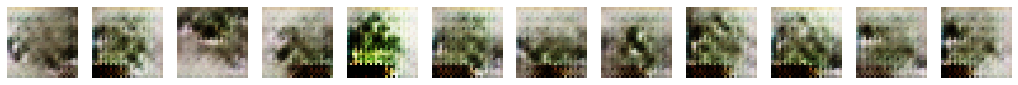

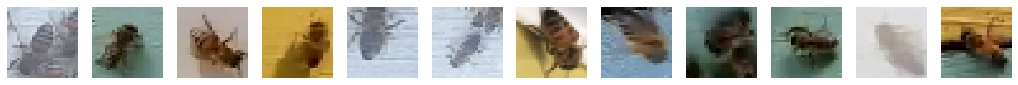

Epoch is 100 GAN loss is 1.0537128 Discriminator loss is 0.53448004


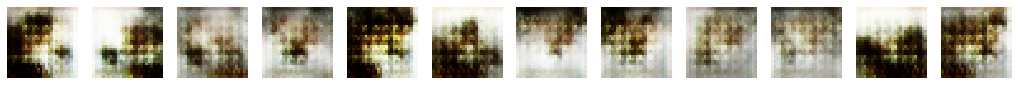

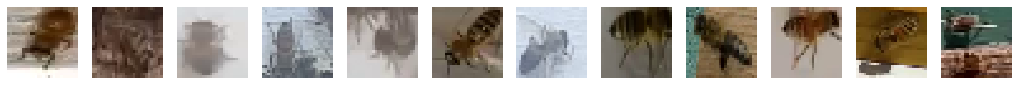

Epoch is 150 GAN loss is 1.0807052 Discriminator loss is 0.5131603


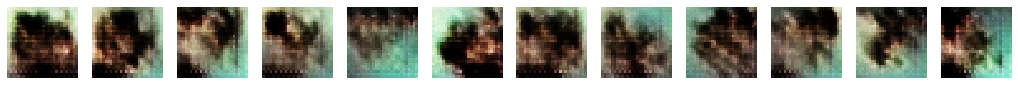

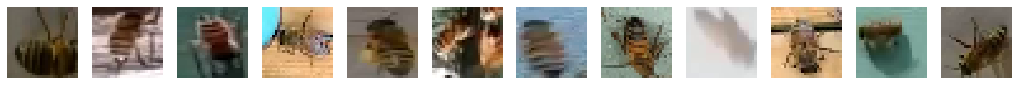

Epoch is 200 GAN loss is 1.2021385 Discriminator loss is 0.5554818


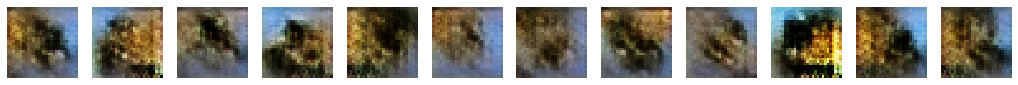

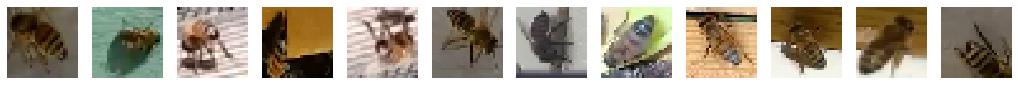

Epoch is 250 GAN loss is 0.8402125 Discriminator loss is 0.5298936


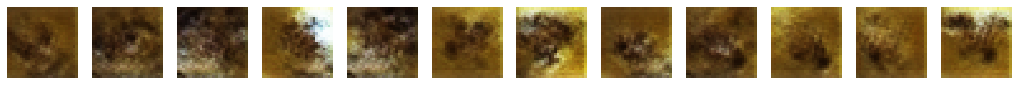

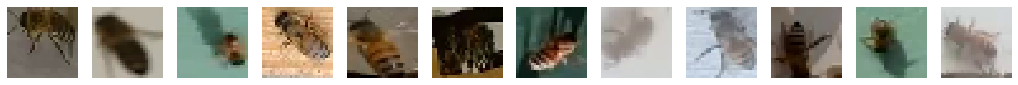

Epoch is 300 GAN loss is 1.1610588 Discriminator loss is 0.5796301


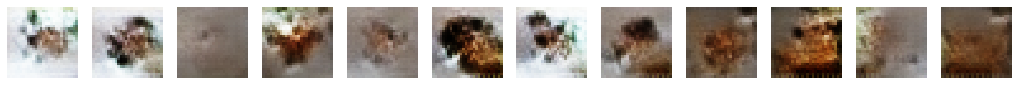

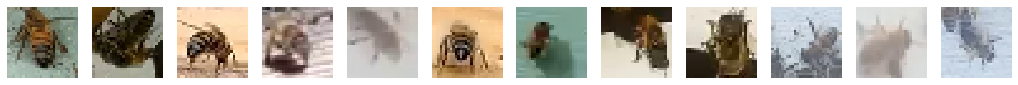

Epoch is 350 GAN loss is 0.9259062 Discriminator loss is 0.6317491


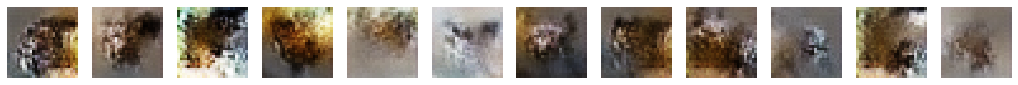

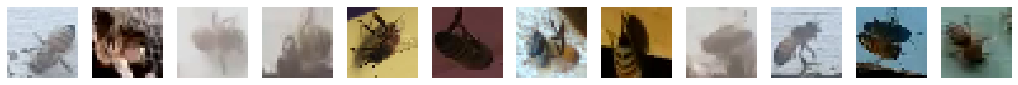

Epoch is 400 GAN loss is 0.95545745 Discriminator loss is 0.5388699


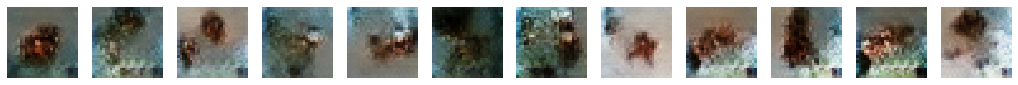

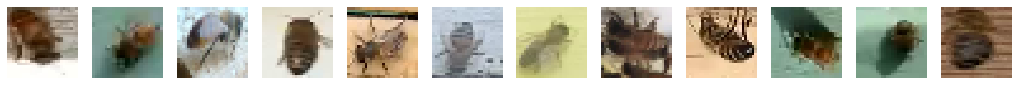

Epoch is 450 GAN loss is 1.1007951 Discriminator loss is 0.55136997


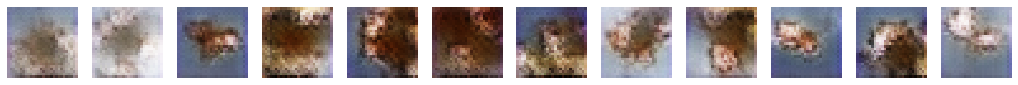

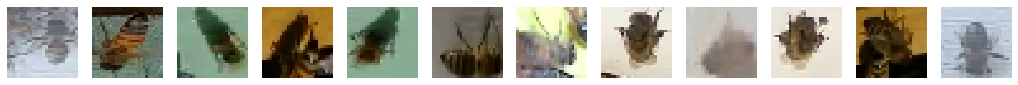

Epoch is 500 GAN loss is 0.95907617 Discriminator loss is 0.56793094


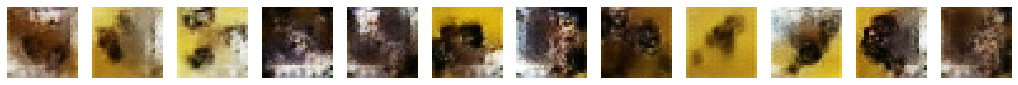

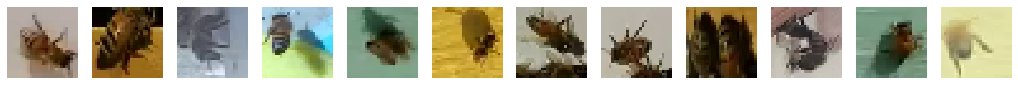

Epoch is 550 GAN loss is 0.9509211 Discriminator loss is 0.5694486


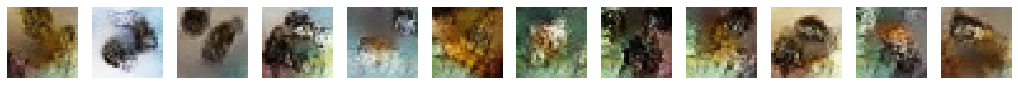

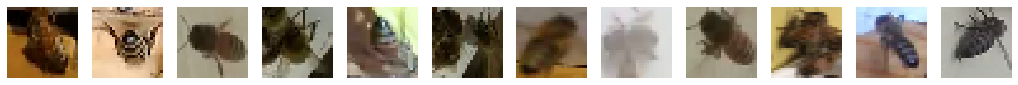

Epoch is 600 GAN loss is 1.0109133 Discriminator loss is 0.5873035


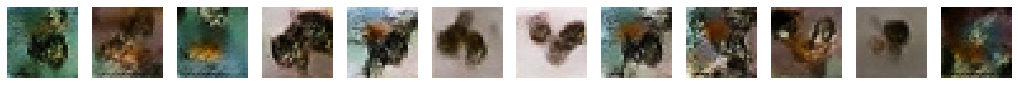

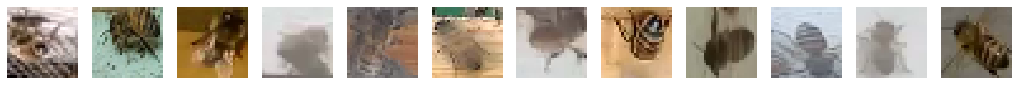

Epoch is 650 GAN loss is 0.79630643 Discriminator loss is 0.60719556


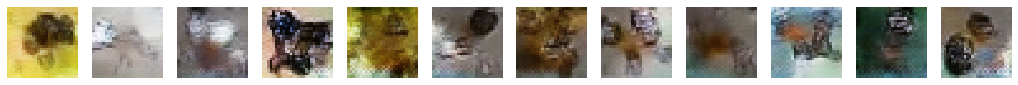

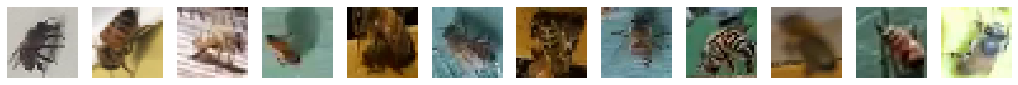

Epoch is 700 GAN loss is 0.87183315 Discriminator loss is 0.6112487


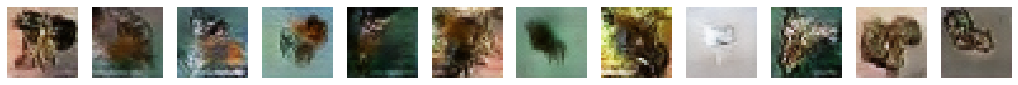

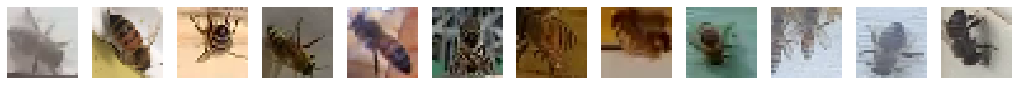

Epoch is 750 GAN loss is 1.03641 Discriminator loss is 0.6149549


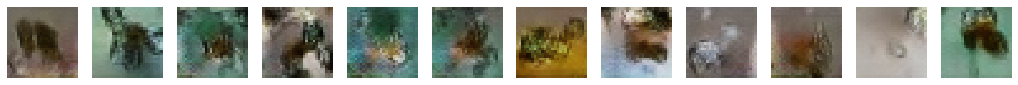

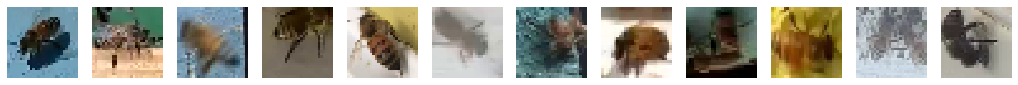

Epoch is 800 GAN loss is 0.8751628 Discriminator loss is 0.6109723


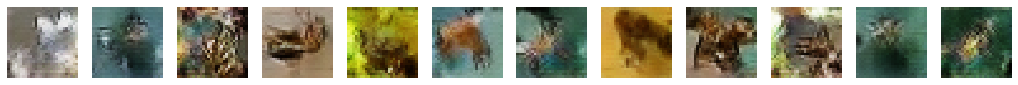

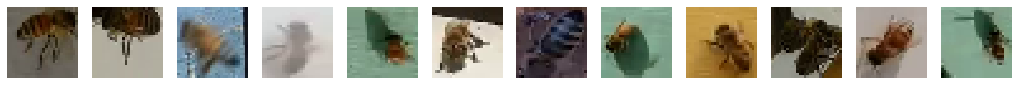

Epoch is 850 GAN loss is 0.892472 Discriminator loss is 0.5736119


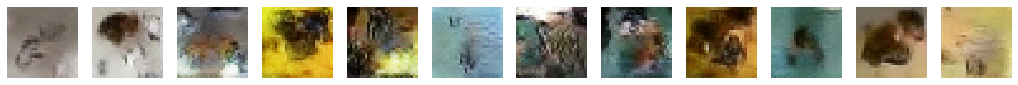

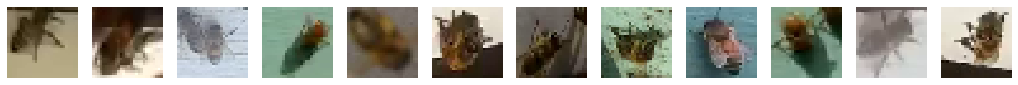

Epoch is 900 GAN loss is 0.8040424 Discriminator loss is 0.6219457


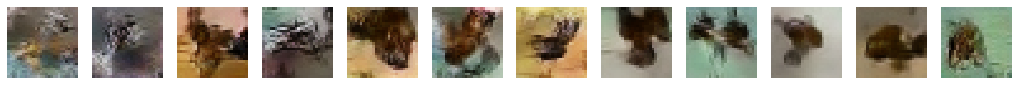

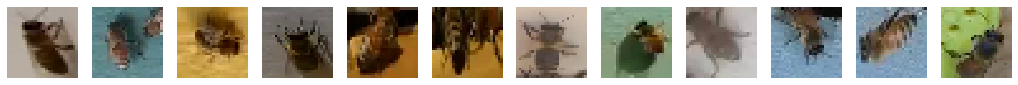

Epoch is 950 GAN loss is 0.8367889 Discriminator loss is 0.622846


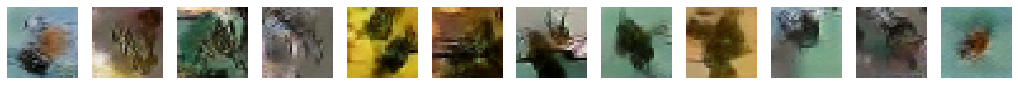

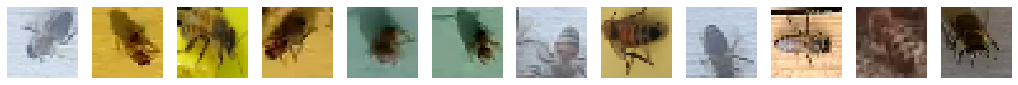

Epoch is 1000 GAN loss is 0.76210594 Discriminator loss is 0.6196541


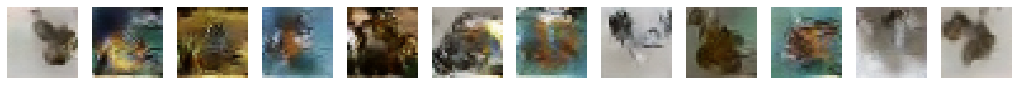

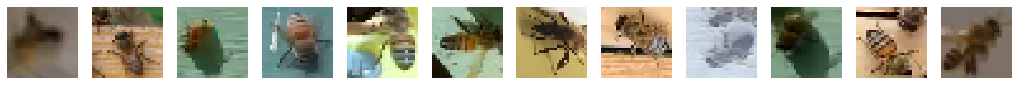

In [125]:
train_gan(gan,train_generator,batch_size,codings_size,1000,num_batches=200)

In [0]:
gan.save_weights("gan_model_weights.h5")

In [128]:
# Import PyDrive and associated libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a text file.
uploaded = drive.CreateFile({'title': 'gan_model_weights.h5'})
#model_file = drive.CreateFile({'title' : 'model.h5'})                       
uploaded.SetContentFile('gan_model_weights.h5')                       
#model_file.Upload()
#uploaded.SetContentString('Sample upload file content')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 13oE867iNjMpbNLMFvfPh2Qqzaf_BH2Ng
